In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, HDBSCAN
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models


In [2]:
def plot(X, labels, probabilities=None, parameters=None, ground_truth=False, ax=None):
    if ax is None:
        _, ax = plt.subplots(figsize=(10, 4))
    labels = labels if labels is not None else np.ones(X.shape[0])
    probabilities = probabilities if probabilities is not None else np.ones(X.shape[0])
    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
    proba_map = {idx: probabilities[idx] for idx in range(len(labels))}
    for k, col in zip(unique_labels, colors):
        if k == -1:
            col = [0, 0, 0, 1]
        class_index = (labels == k).nonzero()[0]
        for ci in class_index:
            ax.plot(
                X[ci, 0],
                X[ci, 1],
                "x" if k == -1 else "o",
                markerfacecolor=tuple(col),
                markeredgecolor="k",
                markersize=4 if k == -1 else 1 + 5 * proba_map[ci],
            )
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    preamble = "True" if ground_truth else "Estimated"
    title = f"{preamble} number of clusters: {n_clusters_}"
    if parameters is not None:
        parameters_str = ", ".join(f"{k}={v}" for k, v in parameters.items())
        title += f" | {parameters_str}"
    ax.set_title(title)
    plt.tight_layout()


In [3]:
# Prepare data
features = [
    'beam_id',
    'ra_hours',
    'dec_degrees',
    'signal_frequency',
    'signal_beam',
    'signal_drift_rate',
    'signal_snr',
    'signal_power',
    'signal_incoherent_power',
]

pd.set_option('display.max_columns', None)
df = pd.read_pickle("data/non_rfi_df.pkl")
#print(df.head(50))
df_without_incoherent = df[(df.source_name != 'Incoherent')]
df_numeric = df_without_incoherent.select_dtypes(include=[np.number]).fillna(0)
filtered_column_df = df_numeric[features]
small_df = filtered_column_df[0:3000]

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(small_df)

Autoencoder

In [8]:
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

# Build autoencoder
input_dim = X_scaled.shape[1]
encoding_dim = 4  # size of bottleneck

input_layer = layers.Input(shape=(input_dim,))
encoded = layers.Dense(16, activation='relu')(input_layer)
encoded = layers.Dense(encoding_dim, activation='relu')(encoded)
decoded = layers.Dense(16, activation='relu')(encoded)
decoded = layers.Dense(input_dim, activation='sigmoid')(decoded)

autoencoder = models.Model(inputs=input_layer, outputs=decoded)
encoder = models.Model(inputs=input_layer, outputs=encoded)

autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(X_scaled, X_scaled, epochs=100, batch_size=32, shuffle=True, verbose=1)

X_encoded = encoder.predict(X_scaled)

Epoch 1/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1339
Epoch 2/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0687
Epoch 3/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0461
Epoch 4/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0352
Epoch 5/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0290
Epoch 6/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0244
Epoch 7/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0204
Epoch 8/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0176
Epoch 9/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0149
Epoch 10/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0134
Epoch 11/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0125
Epoch 12/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0119
Epoch 13/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0114
Epoch 14/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0111
Epoch 15/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0108
Epoc

<Figure size 1000x600 with 0 Axes>

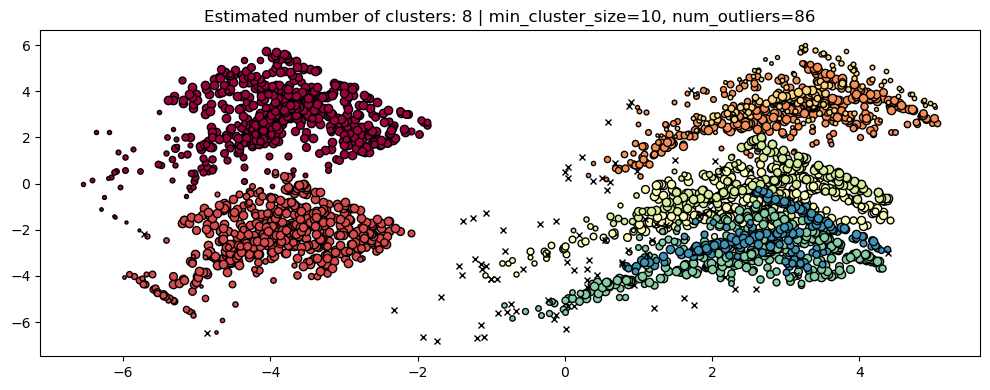

In [9]:
%matplotlib inline
plt.figure(figsize=(10,6))

X = X_encoded

clusterer = HDBSCAN(
    min_cluster_size=10,
    n_jobs=-1,
)

# Fit HDBSCAN
clusterer.fit(X)
labels = clusterer.labels_
probabilities = getattr(clusterer, "probabilities_", None)
num_outliers = np.count_nonzero(np.where(labels==-1))

# Project to 2D for visualization
X_2d = PCA(n_components=2).fit_transform(X)

# Plot clusters
plot(X_2d, labels, probabilities=probabilities, parameters={"min_cluster_size":10, "num_outliers":num_outliers})
plt.show()
